In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
DIR = "C:/Users/vicsa/OneDrive/Documents/Personal/Master_DataScience_UBA/3er Cuatrimestre/Proyecto_Tesis/Data_Tesis/CSV/"
df = pd.read_csv(DIR + "BD_final.csv")
df.head()


,FEC_FIN,year,week,REGION,SUB_REGION,PROVINCIA,DISTRITO,ID,Site Name,AVAILABILITY_NUM,...,cnt_srv_RECTIFICADOR,cnt_srv_SE,cnt_srv_SISTEMA ELECTRICO,cnt_srv_SISTEMA SEGURIDAD,"cnt_srv_Siniestros, Accidentes de Transito, Corto Circuito",cnt_srv_TRABAJOS TERCEROS,cnt_srv_Trabajo de otros Operadores,cnt_srv_UPS,"cnt_srv_Vandalismo(Sabotaje,Robos de Mufa, Robos de cable)",uptime_pct
0,9/12/2023,2023,49,NORTE,LA LIBERTAD,SANCHEZ CARRION,CHUGAY,TJL6046,MACULLIDA,14400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.090909
1,9/12/2023,2023,49,NORTE,AMAZONAS,BONGARA,FLORIDA,TML5579,EL_CHIDO,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
2,9/12/2023,2023,49,NORTE,CAJAMARCA,CHOTA,SAN JUAN DE LICUPIS,TCL5918,LICUPIS,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
3,9/12/2023,2023,49,NORTE,LA LIBERTAD,CHEPEN,PACANGA,TJL5355,PACANGA,390.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.981793
4,9/12/2023,2023,49,NORTE,AMAZONAS,LUYA,SANTO TOMAS,TML5613,SANTO_TOMAS_DE_AMAZONAS,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


# Diversificación de IDs

Durante la etapa inicial del EDA, detecté que algunas estaciones comparten el mismo ID o presentan variaciones mínimas en su codificación debido a decisiones internas de la empresa. Esta situación puede generar ambigüedad en la interpretación de los datos y afectar negativamente tanto el análisis exploratorio como el desempeño del modelo predictivo.

Por ello, previo a la realización del EDA formal, se procedió a un proceso de estandarización y corrección de los identificadores de estación, con el fin de consolidar adecuadamente la información y asegurar la calidad y consistencia del dataset.

## 1. Identificación de conflictos ('Site Name' que comparten el mismo ID)

In [4]:

id_conflictivos = (
    df.groupby('ID')['Site Name']
    .nunique()
    .reset_index()
    .query('`Site Name` > 1')
)

conflictivos_ids = id_conflictivos['ID'].tolist()

print("Conflictos detectados (mismo ID compartido por múltiples 'Site Name'):")
print(df[df['ID'].isin(conflictivos_ids)][['ID', 'Site Name']].drop_duplicates())


Conflictos detectados (mismo ID compartido por múltiples 'Site Name'):
             ID              Site Name
6       TTL3344               UNTUMBES
12      TJL5195             DO_OECHSLE
18      TAL6114              SAN_PEDRO
22      TLL0514          ENTRADA_OLMOS
25      TLL5945              FERRENAFE
...         ...                    ...
176827  TML5576     NAT_TRIUNFO_CHACHA
181499  TLL5961  NAT_CERRO_LA_VIEJA_P1
181565  TJL4948     NAT_LLACUABAMBA_P3
181623  TCL6500          NAT_LA_RETAMA
182436  TJL5231            NAT_BOLIVAR

[762 rows x 2 columns]


## 2. Corrijo estos casos

In [5]:

df_corregido = df.copy()
nuevo_id = df_corregido['ID'].max() if pd.api.types.is_numeric_dtype(df['ID']) else None

for id_conf in conflictivos_ids:
    subset = df_corregido[df_corregido['ID'] == id_conf]
    sitios = subset['Site Name'].unique()
    
   
    if len(sitios) == 0:
        continue

    sitio_referencia = sitios[0]
    for sitio in sitios[1:]:
        if pd.api.types.is_numeric_dtype(df['ID']):
            nuevo_id += 1
            id_nuevo = nuevo_id
        else:
            id_nuevo = f"{id_conf}_{sitio}"
        df_corregido.loc[df_corregido['Site Name'] == sitio, 'ID'] = id_nuevo


## 3. Identificación de casos donde un mismo 'Site Name' tiene múltiples IDs

In [6]:

duplicados_sn = (
    df_corregido.groupby('Site Name')['ID']
    .nunique()
    .reset_index()
    .query('ID > 1')
)

sitios_inconsistentes = duplicados_sn['Site Name'].tolist()

## 4. unificación de IDs por 'Site Name'

In [7]:
for sitio in sitios_inconsistentes:
    id_correcto = (
        df_corregido[df_corregido['Site Name'] == sitio]['ID']
        .mode()
        .iloc[0]
    )
    df_corregido.loc[df_corregido['Site Name'] == sitio, 'ID'] = id_correcto


## 5. Verificación final

In [8]:
verificacion = df_corregido.groupby('Site Name')['ID'].nunique()
inconsistentes_final = verificacion[verificacion > 1]

if inconsistentes_final.empty:
    print("\n Corrección completada. Cada 'Site Name' tiene ahora un único ID consistente.")
else:
    print("\n Aún hay inconsistencias:")
    print(inconsistentes_final)


 Corrección completada. Cada 'Site Name' tiene ahora un único ID consistente.


## 6.Generación de columnas de disponibilidad según tecnologia

Al verificar mi database, identifico que en la misma semana se tiene multiples entradas para una misma estación, solo separadas por la tecnologia (2G/3G/4G)  

In [9]:
dupes = (df_corregido
         .groupby(["Site Name", "year", "week"])
         .agg(n_reg=("TECNOLOGIA", "nunique"),
              techs=("TECNOLOGIA", lambda x: list(x.unique())),
              uptime_var=("uptime_pct", "var"))
         .reset_index())

print(dupes["n_reg"].value_counts().head())  

n_reg
3    42662
2    18715
1    17135
Name: count, dtype: int64


In [10]:
# Variación de disponibilidad entre tecnologías (mismo sitio-semana)
umbral = 0.1
dupes["similar"] = dupes["uptime_var"].fillna(0) < umbral**2

prop_similares = dupes["similar"].mean()
print(f"{prop_similares:.1%} de los sitios con múltiples tecnologías \
tienen uptime prácticamente idéntico")

86.9% de los sitios con múltiples tecnologías tienen uptime prácticamente idéntico


Con el fin de tener una unica entrada semanal por estación y que no se afecte mi modelo. Decidi generar variables para representar la variabilidad de disponibilidad entre estas tecnologias y poder conservar una unica entrada

In [11]:
key_cols = ["Site Name", "year", "week"]

agg_metrics = {
    "uptime_min":  ("uptime_pct", "min"),
    "uptime_mean": ("uptime_pct", "mean"),
    "uptime_max":  ("uptime_pct", "max"),
    "uptime_var":  ("uptime_pct", "var"),
    "n_tech":      ("TECNOLOGIA", "nunique"),
}

other_cols = [c for c in df_corregido.columns
              if c not in key_cols + ["uptime_pct", "TECNOLOGIA"]]


agg_others = {col: (col, "first") for col in other_cols}

agg_dict = {**agg_metrics, **agg_others}

df_model = (df_corregido
                .groupby(key_cols, as_index=False)
                .agg(**agg_dict))

C:\Users\vicsa\AppData\Local\Temp\ipykernel_25500\2001490655.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_model = (df_corregido
C:\Users\vicsa\AppData\Local\Temp\ipykernel_25500\2001490655.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_model = (df_corregido
C:\Users\vicsa\AppData\Local\Temp\ipykernel_25500\2001490655.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

In [12]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78512 entries, 0 to 78511
Columns: 224 entries, Site Name to cnt_srv_Vandalismo(Sabotaje,Robos de Mufa, Robos de cable)
dtypes: float64(210), int64(4), object(10)
memory usage: 134.2+ MB


In [13]:
df_model.to_csv(DIR + "BD_Final_Corregida.csv",   index=False)

# EDA

## 1. Selección de columnas clave para el análisis

In [14]:

cols_needed = ['ID', 'week', 'uptime_min', 'n_alarms', 'ZONA', 'total_dur_min', 'total_dur_caida']
print(df_model.info())
print(df_model.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78512 entries, 0 to 78511
Columns: 224 entries, Site Name to cnt_srv_Vandalismo(Sabotaje,Robos de Mufa, Robos de cable)
dtypes: float64(210), int64(4), object(10)
memory usage: 134.2+ MB
None
               year          week    uptime_min   uptime_mean    uptime_max  \
count  78512.000000  78512.000000  78512.000000  78512.000000  78512.000000   
mean    2023.937602     27.268672     99.199963     99.411737     99.656551   
std        0.241879     14.528183      3.764928      3.177581      2.918443   
min     2023.000000      1.000000      0.000000      0.000000      0.000000   
25%     2024.000000     15.000000     99.970865     99.983466    100.000000   
50%     2024.000000     28.000000    100.000000    100.000000    100.000000   
75%     2024.000000     40.000000    100.000000    100.000000    100.000000   
max     2024.000000     52.000000    100.000000    100.000000    100.000000   

         uptime_var        n_tech  AVAILABILIT

# 2. Verificación de contenido y valores nulos

In [15]:

print("Tamaño:", df_model.shape)
print("\nTipos de datos:")
nulls = df_model.isnull().sum()
nulls = nulls[nulls > 0].sort_values(ascending=False)

print("Columnas con valores nulos:")
print(nulls)

Tamaño: (78512, 224)

Tipos de datos:
Columnas con valores nulos:
cnt_srv_Cable Drop Averiado              72785
cnt_srv_DWDM                             72785
cnt_srv_Daño Interno Cable Canalizado    72785
cnt_srv_LT                               72785
cnt_srv_Daño Interno de Cable Aereo      72785
                                         ...  
total_dur_min                            62101
cnt_fl_1-Critical                        62101
uptime_var                               17006
PROVINCIA                                   58
DISTRITO                                    58
Length: 208, dtype: int64


Durante la etapa de análisis exploratorio se identificó la presencia de valores nulos en una cantidad considerable de variables del dataset, principalmente aquellas relacionadas con el conteo de eventos o fallas específicas (cnt_*), así como en algunas métricas de duración y cantidad de alarmas (n_alarms, total_dur_caida, etc.).

Se procedió a clasificar las variables con valores faltantes en tres categorías:

-   Variables prescindibles: como PROVINCIA y DISTRITO, que no serán utilizadas en el análisis o modelado, y por lo tanto seran elimindas.

-   Variables donde el nulo representa ausencia de evento: se incluyeron aquí todas aquellas columnas donde un valor faltante implica que no se registró ninguna ocurrencia del evento en cuestión durante la semana analizada. Por ejemplo, si una estación no reportó alarmas en una semana, n_alarms figura como nulo. En estos casos, se imputaron los valores faltantes con cero (0), bajo el criterio de que la ausencia de registro equivale a ausencia de ocurrencia.

-   Variables con posible falta real de información: algunas columnas pueden presentar valores faltantes no por ausencia del evento, sino por limitaciones en el registro o captura de datos. Estas se mantuvieron con valores NaN, salvo que se identificara de forma explícita que forman parte de un conjunto mutuamente excluyente (por ejemplo, causas de falla únicas por evento), en cuyo caso también se imputaron con cero.

Dado que estas variables estan entre las que se usaran para el EDA realizare la imputación de valores antes de continuar

In [16]:
cols_evento_directo = [
    'n_alarms', 'total_dur_min', 'total_dur_caida', 'total_dur_corte_ene',
    'cnt_fl_1-Critical', 'cnt_fl_2-High', 'cnt_fl_3-Medium', 'cnt_fl_4-Low'
]
df_model[cols_evento_directo] = df_model[cols_evento_directo].fillna(0)

cols_cnt_dependientes = [col for col in df_model.columns if col.startswith("cnt_") and col not in cols_evento_directo]

for col in cols_cnt_dependientes:
    df_model.loc[df_model['n_alarms'] == 0, col] = df_model.loc[df_model['n_alarms'] == 0, col].fillna(0)

missing_summary = df_model.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print("Columnas con nulos restantes:\n", missing_summary)


Columnas con nulos restantes:
 uptime_var                          17006
cnt_srv_Averia en la PINT           10684
cnt_srv_BB                          10684
cnt_srv_CORTE ENERGIA               10684
cnt_srv_AA                          10684
                                    ...  
cnt_tsc_Energia Comercial               1
cnt_tsc_Energia LTE-TDD                 1
cnt_tsc_FALLA AIRE ACONDICIONADO        1
cnt_tsc_Falla Bateria                   1
cnt_tsc_Falla Energia 65033             1
Length: 200, dtype: int64


## 3. Estadísticas básicas

In [17]:
print("\nEstadísticas:")
print(df_model.describe())


Estadísticas:
               year          week    uptime_min   uptime_mean    uptime_max  \
count  78512.000000  78512.000000  78512.000000  78512.000000  78512.000000   
mean    2023.937602     27.268672     99.199963     99.411737     99.656551   
std        0.241879     14.528183      3.764928      3.177581      2.918443   
min     2023.000000      1.000000      0.000000      0.000000      0.000000   
25%     2024.000000     15.000000     99.970865     99.983466    100.000000   
50%     2024.000000     28.000000    100.000000    100.000000    100.000000   
75%     2024.000000     40.000000    100.000000    100.000000    100.000000   
max     2024.000000     52.000000    100.000000    100.000000    100.000000   

         uptime_var        n_tech  AVAILABILITY_NUM  AVAILABILITY_DEN  \
count  61506.000000  78512.000000      7.851200e+04      7.851200e+04   
mean       2.306879      2.325135      1.032098e+04      3.498669e+06   
std       36.268298      0.809892      6.646353e+04   

In [18]:
df_model['ID'].nunique()

1772

In [19]:
resumen_disponibilidad = df_model.groupby('ZONA')['uptime_min'].agg(
    mean='mean',
    std='std',
    min='min',
    max='max',
    count='count'
).round(3)

# Ver la tabla
print(resumen_disponibilidad)

            mean    std    min    max  count
ZONA                                        
REGION_A  99.017  4.194  2.510  100.0   2993
REGION_B  99.316  3.882  0.000  100.0   7885
REGION_C  99.497  2.441  0.000  100.0  10239
REGION_D  99.039  3.775  0.000  100.0   5861
REGION_E  99.002  4.209  5.696  100.0   2794
REGION_F  98.894  5.088  0.000  100.0   6866
REGION_G  98.409  4.986  0.000  100.0   3856
REGION_H  99.232  3.513  0.000  100.0  14039
REGION_I  99.267  3.677  0.000  100.0  20477
REGION_J  99.604  2.313  7.103  100.0   3502


## 4. Histograma de uptime_min

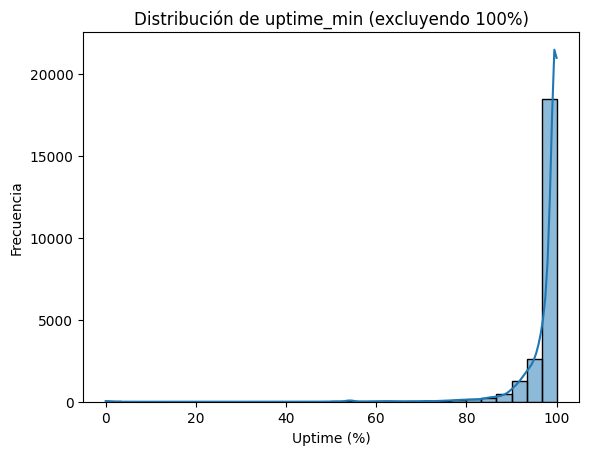

In [20]:

df_filtrado = df_model[df_model['uptime_min'] < 100]

sns.histplot(df_filtrado['uptime_min'], bins=30, kde=True)
plt.title('Distribución de uptime_min (excluyendo 100%)')
plt.xlabel('Uptime (%)')
plt.ylabel('Frecuencia')
plt.show()

Al analizar la distribución de la disponibilidad (uptime_min) se observa una altísima concentración en valores de 100%, lo cual sugiere que la mayoría de estaciones no presentan caídas durante las semanas observadas. Esta concentración produce un pico extremo en el histograma, dificultando la visualización del comportamiento en valores inferiores. Se optó por aplicar un filtro (<100%) para estudiar mejor la dispersión restante y detectar posibles patrones o anomalías.

##  5. Promedio Semanal uptime_min según Zona 

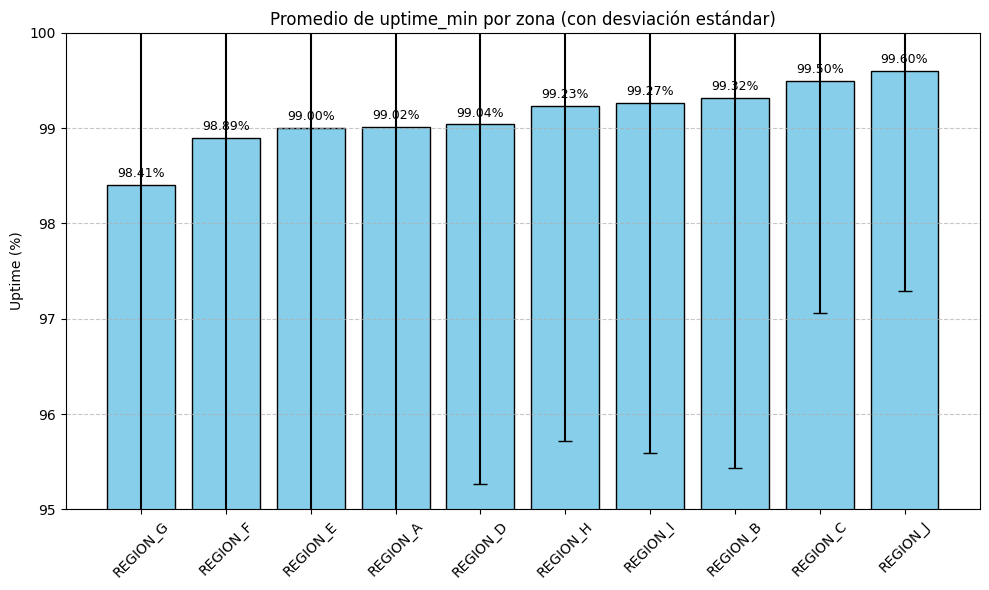

In [21]:
agg = df_model.groupby('ZONA')['uptime_min'].agg(['mean', 'std']).sort_values('mean')

plt.figure(figsize=(10,6))
bars = plt.bar(agg.index, agg['mean'], yerr=agg['std'], capsize=5,
               color='skyblue', edgecolor='black')

for bar, uptime in zip(bars, agg['mean']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05,
             f'{uptime:.2f}%', ha='center', va='bottom', fontsize=9)

plt.ylabel('Uptime (%)')
plt.ylim(95, 100)
plt.xticks(rotation=45)
plt.title('Promedio de uptime_min por zona (con desviación estándar)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

El gráfico presenta el promedio semanal de disponibilidad (uptime_min) por zona geográfica en la red dorsal, acompañado de su desviación estándar. Se evidencia que todas las regiones mantienen niveles de uptime superiores al 95%, aunque con variaciones leves entre zonas. Estas diferencias pueden estar relacionadas con factores como la infraestructura local, condiciones ambientales o la frecuencia de mantenimiento. La desviación estándar permite detectar zonas con mayor dispersión, lo que podría reflejar una mayor inestabilidad operativa.

## 6. Descripción estadistica según zona

In [22]:
df_grouped = df_model.groupby("ZONA")["uptime_min"].agg(["mean", "std", "min", "max"])
df_grouped

,mean,std,min,max
ZONA,,,,
REGION_A,99.017112,4.194051,2.510127,100.0
REGION_B,99.315686,3.881779,0.000000,100.0
REGION_C,99.497400,2.440575,0.000000,100.0
REGION_D,99.039312,3.774621,0.000000,100.0
REGION_E,99.001563,4.208525,5.696098,100.0
REGION_F,98.894486,5.088450,0.000000,100.0
REGION_G,98.408632,4.986059,0.000000,100.0
REGION_H,99.231678,3.512962,0.000000,100.0
REGION_I,99.266981,3.676949,0.000000,100.0


## 7.Gráficos de control de uptime_min por zona

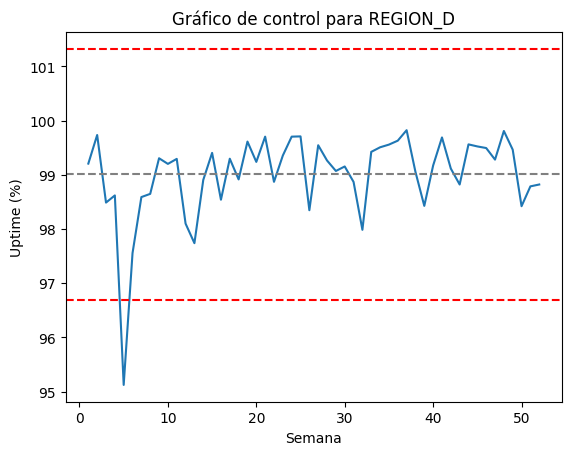

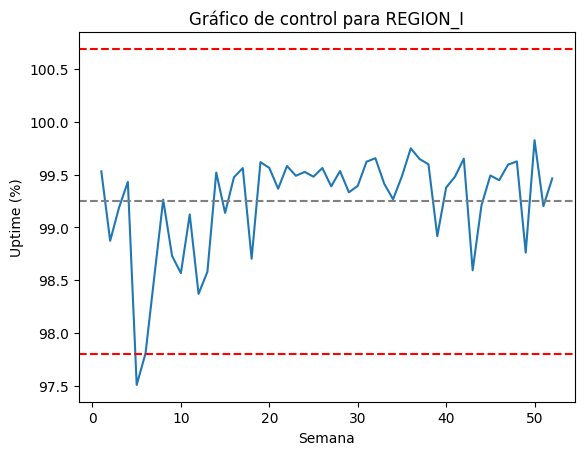

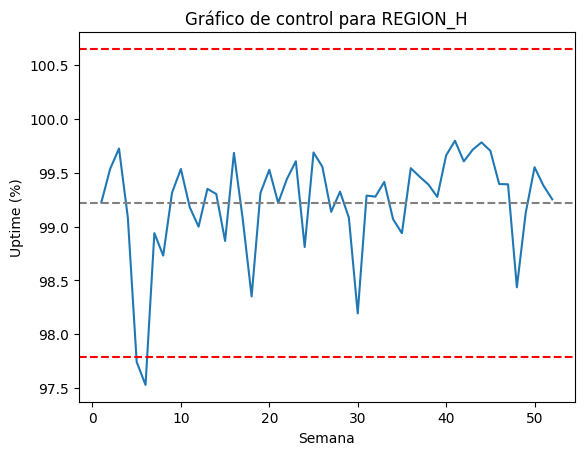

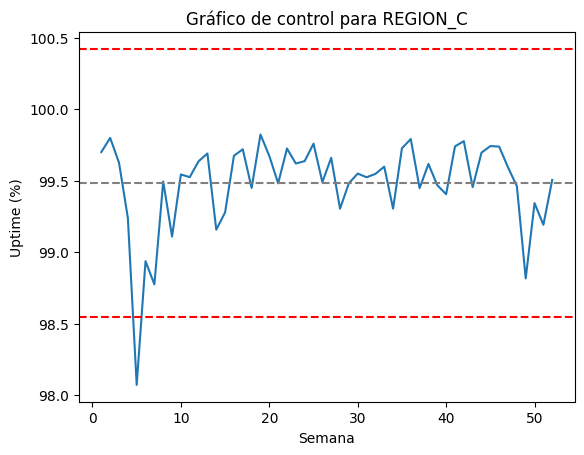

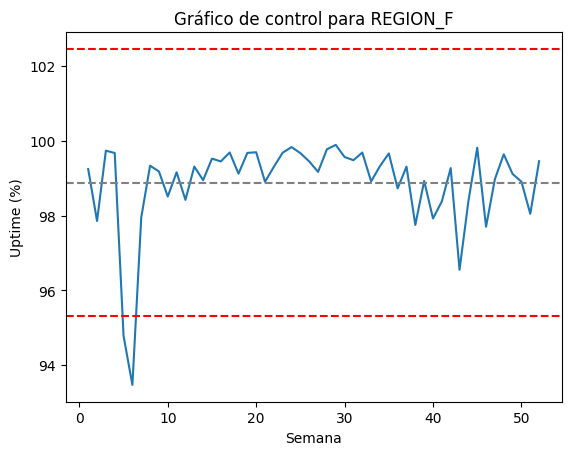

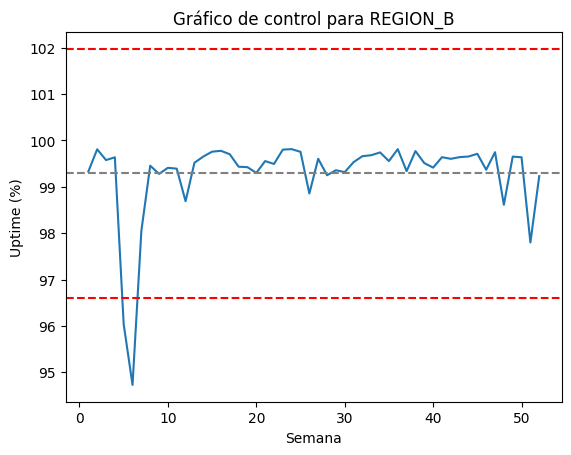

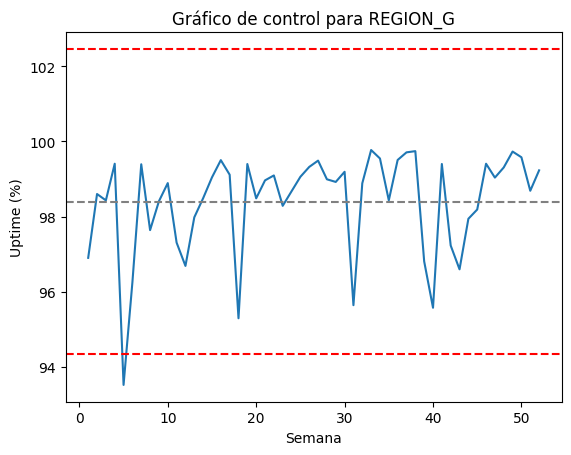

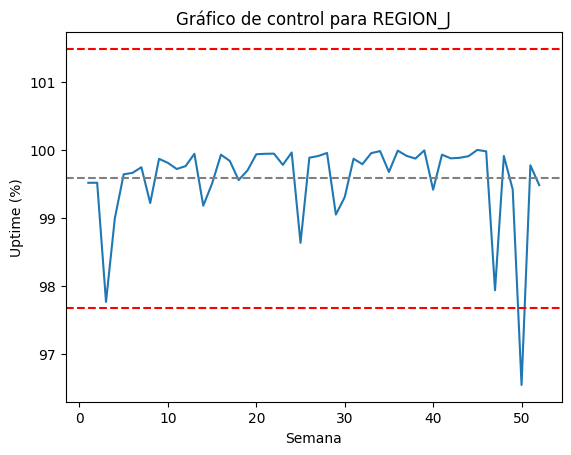

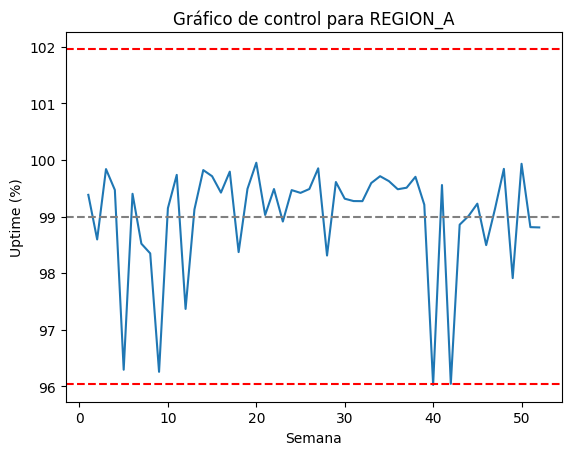

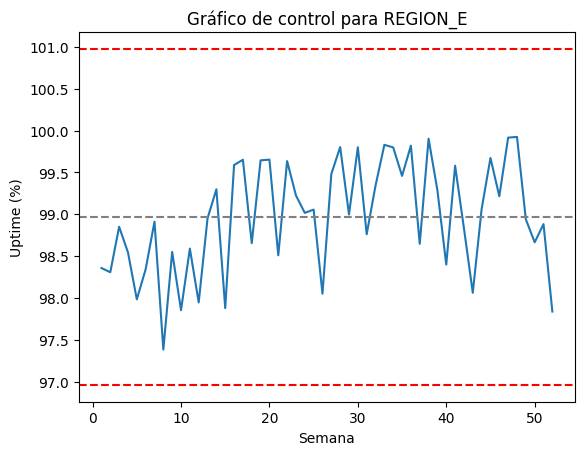

In [23]:
for zona in df_model['ZONA'].unique():
    df_zona = df_model[df_model['ZONA'] == zona].groupby('week')['uptime_min'].mean()
    mu = df_zona.mean()
    sigma = df_zona.std()

    plt.plot(df_zona.index, df_zona, label=zona)
    plt.axhline(mu, color='gray', linestyle='--')
    plt.axhline(mu + 3*sigma, color='red', linestyle='--')
    plt.axhline(mu - 3*sigma, color='red', linestyle='--')
    plt.title(f"Gráfico de control para {zona}")
    plt.xlabel("Semana")
    plt.ylabel("Uptime (%)")
    plt.show()

## 8. Clasificación de estaciones por nivel de riesgo (Clustering)

In [24]:
df_cluster = df_model.groupby('ID').agg({
    'uptime_min': ['mean', 'std'],
    'n_alarms': 'mean',
    'total_dur_caida': 'mean'
}).reset_index()
df_cluster.columns = ['ID', 'avg_uptime', 'std_uptime', 'avg_alarms', 'avg_downtime']

df_cluster[['avg_alarms', 'avg_downtime']] = df_cluster[['avg_alarms', 'avg_downtime']].fillna(0)
df_cluster = df_cluster.dropna() 

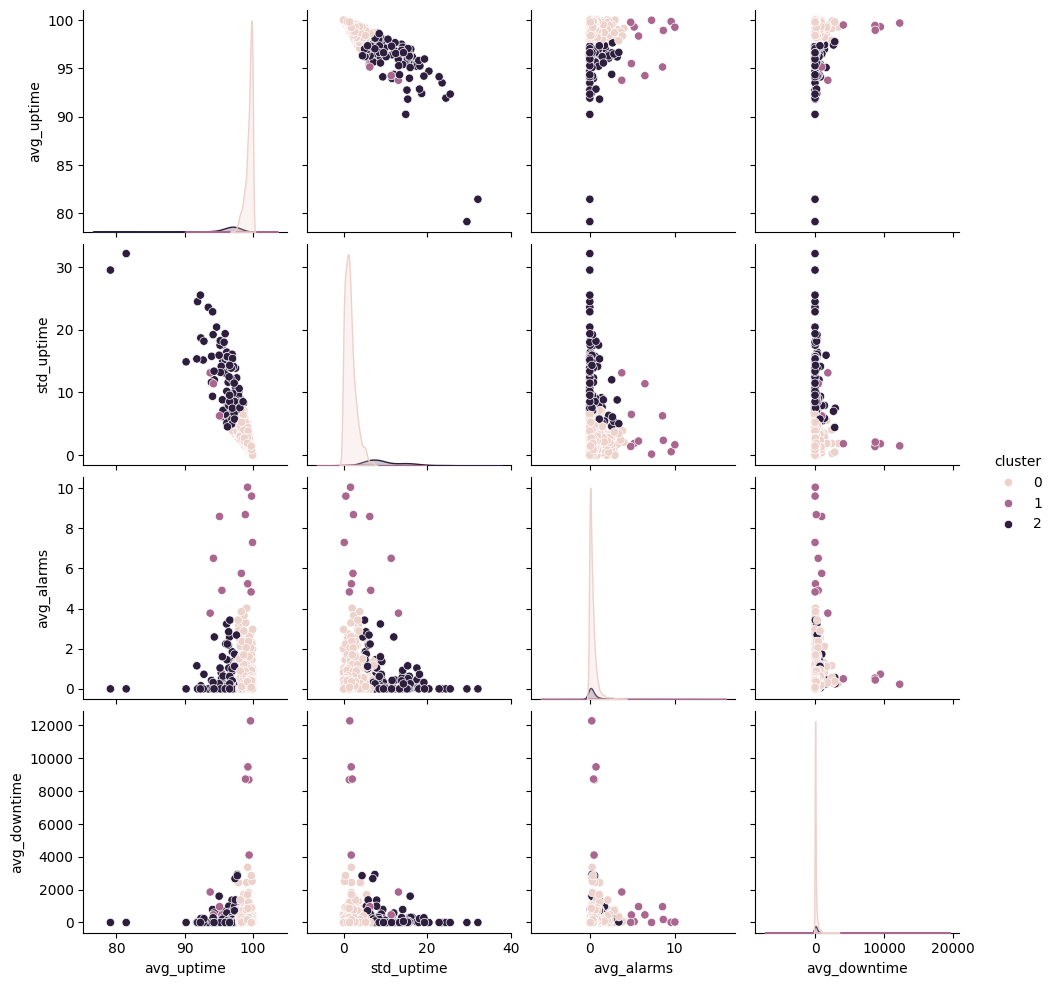

In [25]:
X = df_cluster.drop('ID', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

import seaborn as sns
sns.pairplot(df_cluster, hue='cluster', vars=X.columns)

Se aplicó una técnica de clustering (K-Means) sobre las estaciones considerando métricas agregadas por semana. El modelo identificó tres perfiles claramente diferenciados:

-   Clúster 0 agrupa estaciones estables con alta disponibilidad y prácticamente sin eventos.
-   Clúster 1 incluye estaciones con alta disponibilidad pero variabilidad significativa, lo que podría indicar comportamiento irregular o intermitente.
-   Clúster 2 destaca por una baja disponibilidad combinada con un monitoreo deficiente, evidenciado por el alto tiempo de caída y bajo número de alarmas.

Esta segmentación permite orientar decisiones de mantenimiento, priorizar mejoras tecnológicas y ajustar sistemas de monitoreo para reducir el riesgo operacional.

## 9. Tendencia de uptime en 5 estaciones aleatorias

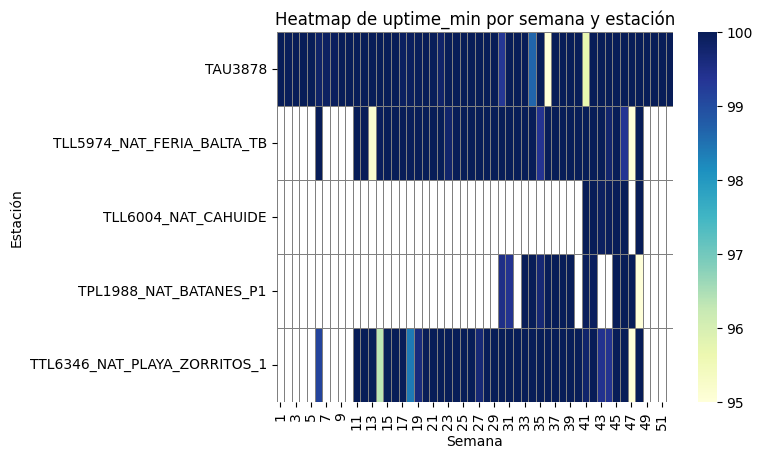

In [26]:

sample_sites = np.random.choice(df_model['ID'].dropna().unique(), size=5, replace=False)

df_pivot = df_model[df_model['ID'].isin(sample_sites)].pivot(index='ID', columns='week', values='uptime_min')
sns.heatmap(df_pivot, cmap="YlGnBu", vmin=95, vmax=100, linewidths=0.5, linecolor='gray')
plt.title("Heatmap de uptime_min por semana y estación")
plt.xlabel("Semana")
plt.ylabel("Estación")
plt.show()

## 10. Correlaciones

In [27]:
print("\nCorrelaciones:")
print(df_model[['uptime_min', 'n_alarms', 'total_dur_min', 'total_dur_caida']].corr())


Correlaciones:
                 uptime_min  n_alarms  total_dur_min  total_dur_caida
uptime_min         1.000000 -0.159989      -0.050940        -0.056429
n_alarms          -0.159989  1.000000       0.247388         0.083667
total_dur_min     -0.050940  0.247388       1.000000         0.717717
total_dur_caida   -0.056429  0.083667       0.717717         1.000000


El análisis de correlación lineal mostró que la métrica de disponibilidad (uptime_pct) tiene una relación débil con el número de alarmas y con la duración de las caídas. En particular, la correlación con n_alarms fue de apenas -0.15, y con total_dur_caida de -0.051, lo que sugiere que las alarmas no siempre reflejan adecuadamente la severidad o impacto de los eventos.

En contraste, se encontró una correlación alta (r = 0.718) entre total_dur_min y total_dur_caida, indicando que ambas variables capturan aspectos coherentes del tiempo afectado. Esta diferencia resalta la necesidad de auditar el sistema de alarmas, ya que la baja correlación con caídas sugiere posibles fallos de detección o configuración inadecuada.

In [ ]:
# Calcular media global de uptime_pct
media_global_uptime = df_model['uptime_min'].mean()

# Calcular desviación estándar por zona
std_por_zona = df_model.groupby('ZONA')['uptime_min'].std().sort_values(ascending=False)

# Calcular correlación entre n_alarms y uptime_pct
correlacion = df_model[['n_alarms', 'uptime_min']].corr().loc['n_alarms', 'uptime_min']

# Seleccionar las dos zonas con mayor varianza
zonas_mayor_var = std_por_zona.head(2)

(media_global_uptime, zonas_mayor_var, correlacion)

(np.float64(99.1999627780934),
 ZONA
 REGION_F    5.088450
 REGION_G    4.986059
 Name: uptime_min, dtype: float64,
 np.float64(-0.15998885495380807))

: 